### Imports and Setup

In [3]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import itertools
from sklearn.cluster import AgglomerativeClustering as SingleLinkage
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_t
import pandas as pd
from matplotlib.offsetbox import AnchoredText

### Dataset Creation Functions

In [6]:
def TwoGuassians(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = np.random.multivariate_normal(np.zeros(dim),  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u,  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    
    return X

In [4]:
def TwoT_Student(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0, degrees=2):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = multivariate_t.rvs(np.zeros(dim), np.multiply(c,np.power(dim,power)*np.identity(dim)), df=degrees, size=NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = multivariate_t.rvs(u, np.multiply(c,np.power(dim,power)*np.identity(dim)), df=degrees, size=NumPointsInCluster)
    
    return X

In [5]:
#Takes in a d-dimensional dataset X and appends guassian noise
def PlusGuassian(X, dimension):
    #X_new = np.zeros((X.shape[0], X.shape[1]+dimension))
    #X_new[:,0:X.shape[1]-1] = np.add(X_new[:,0:X.shape[1]-1], X)# = np.copy(X)
    #print(X_new)
    #print(X_new[:,X.shape[1]:dimension+X.shape[1]].shape)
    #X_new[:,X.shape[1]:dimension+X.shape[1]] = 
    Noise = np.random.multivariate_normal(np.zeros(dimension),  np.power(dimension,-3/4)*np.identity(dimension), size = X.shape[0])
    
    return np.concatenate((X, Noise), axis=1)

In [6]:
#n needs to be divisible by 25
def makeAmongUS(n, dim):
    
    Xs = np.zeros((n, dim))

    ptsPerShare = n/12.5

    n1 = int(3*ptsPerShare)
    n2 = int(2*ptsPerShare)
    n3 = int(1.5*ptsPerShare)
    n4 = int(1*ptsPerShare)
    n5 = int(1*ptsPerShare)
    n6 = int(1*ptsPerShare)
    n7 = int(2*ptsPerShare)


    #part 1
    pts = np.linspace(0,2*np.pi, num=n1)
    dataX = 0.5*np.cos(pts)+0.3
    dataY = 0.25*np.sin(pts)+1

    Xs[:n1,0]=dataX 
    Xs[:n1,1]=dataY

    #part2 
    pts = np.linspace(0.116, 1, num=n2)
    dataX = 0.5*np.cos(np.pi*pts)
    dataY = 0.66*np.sin(np.pi*pts)+1

    Xs[n1:n1+n2,0]=dataX 
    Xs[n1:n1+n2,1]=dataY

    #part3 
    pts = np.linspace(0, 1, num=n3)
    dataX = -0.5*np.ones(pts.shape)
    dataY = pts

    Xs[n1+n2:n1+n2+n3,0]=dataX 
    Xs[n1+n2:n1+n2+n3,1]=dataY

    #part4 
    pts = np.linspace(0, 0.76, num=n4)
    dataX = 0.47*np.ones(pts.shape)
    dataY = pts

    Xs[n1+n2+n3:n1+n2+n3+n4,0]=dataX 
    Xs[n1+n2+n3:n1+n2+n3+n4,1]=dataY

    #part5
    pts = np.linspace(0, 1, num=n5)
    dataX = 0.25*np.cos(np.pi*pts)-0.25
    dataY = -0.25*np.sin(np.pi*pts)

    Xs[n1+n2+n3+n4:n1+n2+n3+n4+n5,0]=dataX 
    Xs[n1+n2+n3+n4:n1+n2+n3+n4+n5,1]=dataY

    #part6
    pts = np.linspace(0, 1, num=n6)
    dataX = (0.47/2)*np.cos(np.pi*pts)+(0.47/2)
    dataY = -(0.47/2)*np.sin(np.pi*pts)

    Xs[n1+n2+n3+n4+n5:n1+n2+n3+n4+n5+n6,0]=dataX 
    Xs[n1+n2+n3+n4+n5:n1+n2+n3+n4+n5+n6,1]=dataY

    #part7
    pts = np.linspace(0, 1, num=n7)
    dataX = 0.25*np.cos(np.pi*pts+np.pi/2)-0.5
    dataY = 0.5*np.sin(np.pi*pts+np.pi/2)+0.5

    Xs[n1+n2+n3+n4+n5+n6:n1+n2+n3+n4+n5+n6+n7,0]=dataX 
    Xs[n1+n2+n3+n4+n5+n6:n1+n2+n3+n4+n5+n6+n7,1]=dataY


    plt.scatter(Xs[:,0], Xs[:,1])
    plt.show()
    
    return Xs

In [7]:
#Double Centering Matrix
def generateH(n):
    return np.eye(n) - np.ones((n, n)) / n

#Takes in distance matrix and returns gram matrix
def gramArray(D):
    H = generateH(D.shape[0])
    return -0.5 * H @ D @ H

#Creates D^2 matrix given gram matrix X in R^(n x n) where n is number of points
def distanceSquaredArray2(XtX):
    n = XtX.shape[0]
    D_squared = np.zeros((n,n))
    for i,j in itertools.product(range(0,n),range(0,n)):
        D_squared[i][j] = XtX[i][i] - 2*XtX[i][j] + XtX[j][j]
    return D_squared

In [8]:
def makeEsimplex(X, eps):
    if eps <= 0 or eps>= 1:
        print('Failure: Epsilon not in (0,1)')
        return X
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    
    #Handle case where X is already an eps-simplex
    if Dmin/Dmax > (1-eps)/(1+eps):
        Xnew = np.multiply((1+eps)/Dmax, X)
        
        #Double check work
        D = distanceSquaredArray2(np.matmul(Xnew, np.transpose(Xnew)))
        Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
        Dmax = np.max(D)
        print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
        
        return Xnew
    
    #Create eps-simplex distance matrix
    A = (1/(2*eps))*((1-eps)*Dmax - (1+eps)*Dmin)
    B = (2*eps)/(Dmax-Dmin)
    
    D = B*(D + np.multiply(A,(np.ones(np.shape(D))-np.identity(D[0].shape[0]))))
    
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
    
    n = D.shape[0]
    
    #Centering matrix
    H = np.eye(n) - np.ones((n, n)) / n

    #Computing inner product matrix
    B = -0.5 * H @ D @ H

    #Eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    
    #Deal with numerical issues where the smallest eigenvalue is just barely negative
    if np.min(eigvals) < 0:
        B = B-np.min(eigvals)
    
    Xnew = np.linalg.cholesky(B)
    
    return Xnew



#Give epsilon simplex distance matrix
def makeEsimplexDistance(X, eps):
    if eps <= 0 or eps>= 1:
        print('Failure: Epsilon not in (0,1)')
        return X
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    
    #Handle case where X is already an eps-simplex
    if Dmin/Dmax > (1-eps)/(1+eps):
        Xnew = np.multiply((1+eps)/Dmax, X)
        
        #Double check work
        D = distanceSquaredArray2(np.matmul(Xnew, np.transpose(Xnew)))
        Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
        Dmax = np.max(D)
        print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
        
        return D
    
    #Create eps-simplex distance matrix
    A = (1/(2*eps))*((1-eps)*Dmax - (1+eps)*Dmin)
    B = (2*eps)/(Dmax-Dmin)
    
    print('A = ' + str(A) + ', B = '+ str(B))
    
    D = B*(D + np.multiply(A,(np.ones(np.shape(D))-np.identity(D[0].shape[0]))))
    
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
    
    
    return D

#Give epsilon simplex distance matrix
def makeEsimplexDistance(X, C, decimals = 8):
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X))) 
    
    if C < 0 or C>1:
        print('Failure: C out of bounds.')
        return D
    
    A = np.round(C/np.max(D), decimals = decimals)
    
    D = A*D + (np.ones(np.shape(D))-np.identity(D[0].shape[0]))
    
    return D

### Figure Making

#### Different Input Of Same Dimension, Same Output

In [108]:
n=100


'''
#works but t-student ASS could be higher
dimensions = [2000, 2000]
powers=[-0.75, -0.75]
C=[1.0, 1.0]
#distance=5 and degrees=5 for t-student
'''


dimensions = [3000, 3000]
powers=[-0.75, -0.75]
C=[1.0, 1.0]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in range(len(dimensions)):
    if i == 0:
        X = TwoT_Student(NumPointsInCluster=n ,distance=5, dim=dimensions[i], power=powers[i], c=C[i], degrees=5)
    if i==1:
        X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i], power=powers[i], c=C[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

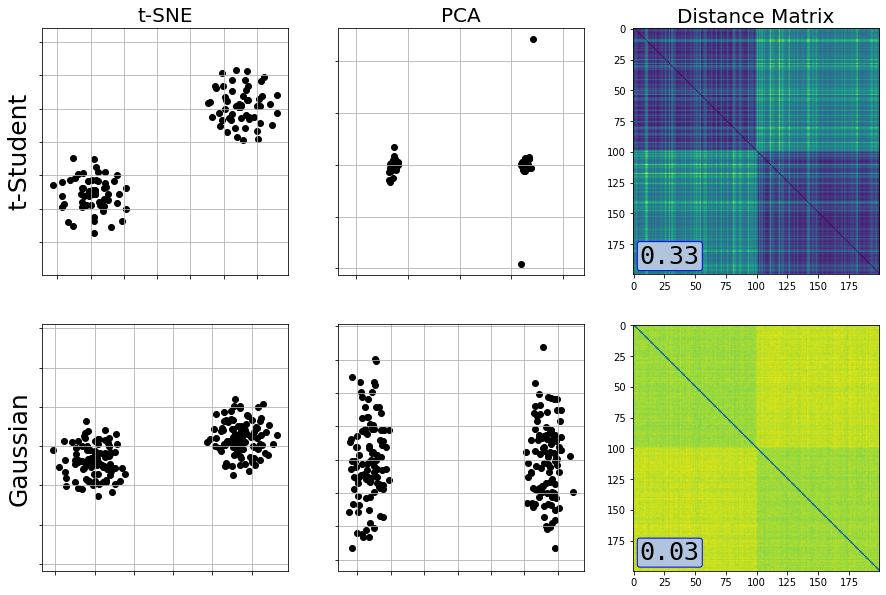

In [111]:
#Creating Figure
fig, ax = plt.subplots(nrows=len(Ds), ncols=3)#, gridspec_kw={'width_ratios': [2, 1]})
fig.set_figwidth(15)
fig.set_figheight(5*len(dimensions))

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    #Run PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(Xs[i])

    # Plot PCA and t-SNE result
    ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", c="black", alpha=1)
    ax[i, 1].scatter(X_pca[:,0], X_pca[:,1], marker="o", c='black', alpha=1)
    
    ax[i, 0].grid('on')
    ax[i, 0].axis('equal')
    ax[i, 0].set_xticklabels([])
    ax[i, 0].set_yticklabels([])
    
    ax[i, 1].grid('on')
    ax[i, 1].axis('equal')
    ax[i, 1].set_xticklabels([])
    ax[i, 1].set_yticklabels([])
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ax[i, 2].imshow(Ds[i])
    
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    ax[i, 2].text(5, 175, str(np.round(ASS,decimals=2)), verticalalignment='top', fontsize=25, weight='light', 
                  family='monospace', bbox = {'facecolor': 'lightsteelblue', 'alpha': 1, 'boxstyle': "round,pad=0.1", 'ec': 'b'})
    
    '''
    ASS = silhouette_score(np.column_stack((Y_xaxis, Y_yaxis)), np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    ax[i, 2].text(-234, 175, str(np.round(ASS,decimals=2)), verticalalignment='top', fontsize=25, weight='light', 
                  family='monospace', bbox = {'facecolor': 'lightsteelblue', 'alpha': 1, 'boxstyle': "round,pad=0.1", 'ec': 'b'})
    
    ASS = silhouette_score(X_pca, np.concatenate((np.ones(n),np.zeros(n))))
    ax[i, 2].text(-475, 175, str(np.round(ASS,decimals=2)), verticalalignment='top', fontsize=25, weight='light', 
                  family='monospace', bbox = {'facecolor': 'lightsteelblue', 'alpha': 1, 'boxstyle': "round,pad=0.1", 'ec': 'b'})
    '''
    
    #Set labels
    if i==0:
        ax[i, 0].set_ylabel('t-Student', fontsize=25)
    elif i==1:
        ax[i, 0].set_ylabel('Gaussian', fontsize=25)

    
    if i==0:
        ax[i, 0].set_title('t-SNE', fontsize=20)
        ax[i, 2].set_title('Distance Matrix', fontsize = 20) #of Student\'s t-Distribution')
        ax[i, 1].set_title('PCA', fontsize=20)

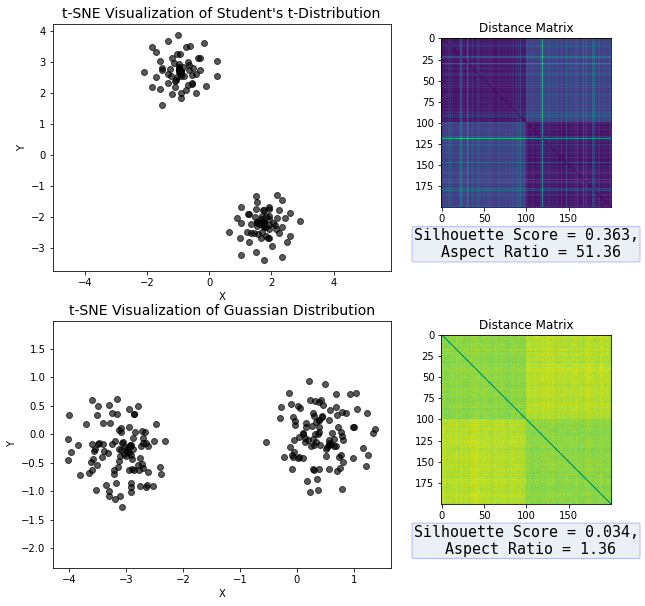

In [ ]:
#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds), gridspec_kw={'width_ratios': [2, 1]})
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", cmap="bwr_r", alpha=0.65)
    if i==0:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization of Student\'s t-Distribution', fontsize=14, weight='light')
    if i==1:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization of Guassian Distribution', fontsize=14, weight='light')
        
    ax[i, 0].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[i, 1].imshow(Ds[i])
    #ax[i, 1].set_xlabel(xlabel='Silhouette Score = ' + str(np.round(ASS,decimals=3))+',\n Aspect Ratio = '+ str(np.round(aspectRatio,decimals=2)),
                        fontsize=15, weight='light', family='monospace', bbox = {'facecolor': 'lightsteelblue', 'alpha': 0.25, 'boxstyle': "round,pad=0.1", 'ec': 'b'})
    
    #ax[i, 1].figtext(0.5, 0.01, 'Silhouette Score = ' + str(np.round(ASS,decimals=3))+',\n Aspect Ratio = '+ str(np.round(aspectRatio,decimals=2)), 
                        #fontsize=15, weight='light', family='monospace')
        
    ax[1, i].text(5, 175, str(np.round(aspectRatio,decimals=2)), verticalalignment='top', fontsize=25, weight='light', 
      
    
    pos1 = ax[i, 1].get_position()  # Get current position
    new_position = [pos1.x0, pos1.y0+0.035, pos1.width, pos1.height]  # Halve the height
    ax[i, 1].set_position(new_position)
    
    if i ==0:
        ax[i, 1].set(title='Distance Matrix') #of Student\'s t-Distribution')
    if i ==1:
        ax[i, 1].set(title='Distance Matrix') #of Guassian Distribution')

In [112]:
name = 'Same_Output_Diff_Input_in_same_dim_9_22_25'
fig.savefig(name+'.png')
fig.savefig(name+'.jpg')

#### Figure 6: Different Input, Same output

In [119]:
n=100

''' This one works pretty well
dimensions = [100, 500, 1000, 3000]
powers=[-0.75, -0.75, -0.75, -0.75]
C=[0.50, 0.75, 1.0, 1.75]
'''

dimensions = [250, 500, 1000, 2000, 4000]
powers=[-0.75, -0.75, -0.75, -0.75, -0.75]
C=[0.70, 0.75, 0.90, 1.15, 1.40]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in range(len(dimensions)):
    X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i], power=powers[i], c=C[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

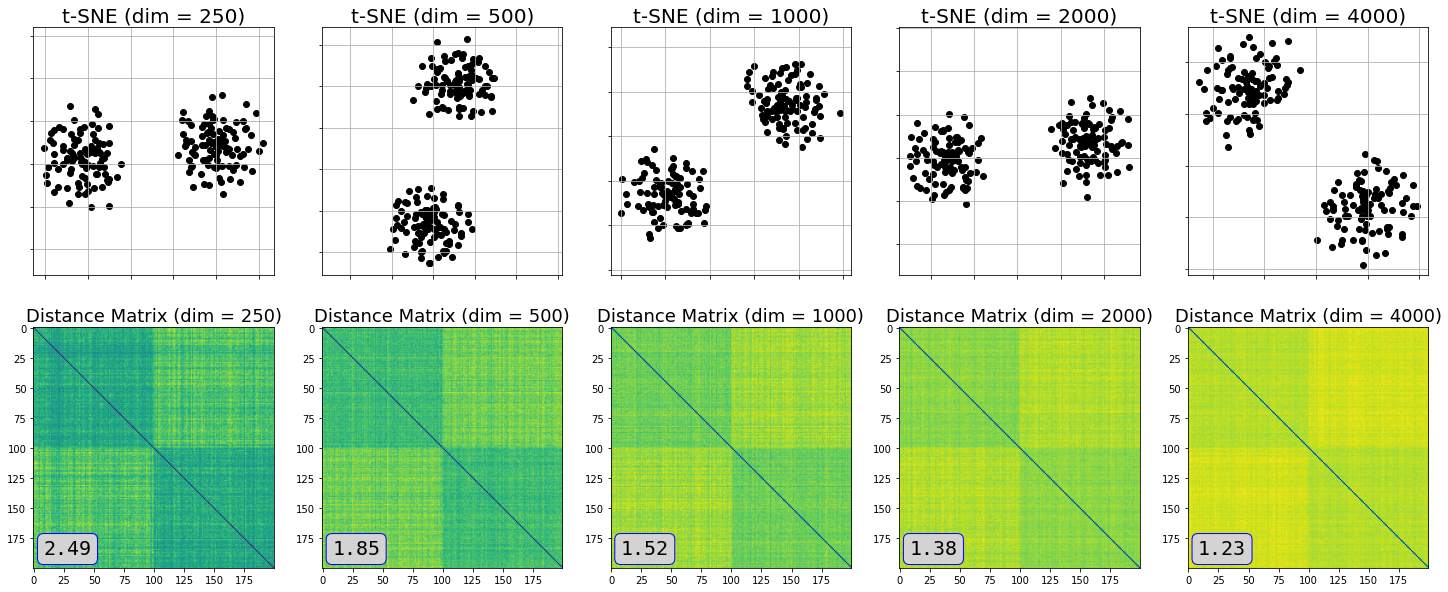

In [128]:
#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds))
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[0, i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=1)
    ax[0, i].set_title('t-SNE (dim = '+ str(dimensions[i])+')', fontsize='20')
    #ax[0, i].set(xlabel='X', ylabel='Y')
    ax[0, i].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[1, i].imshow(Ds[i])
    ax[1, i].set_title('Distance Matrix (dim = '+ str(dimensions[i])+')', fontsize='18')
    
    ax[1, i].text(8, 176, str(np.round(aspectRatio,decimals=2)), verticalalignment='top', fontsize=20, weight='light', 
                  family='monospace', bbox = {'facecolor': 'lightgrey', 'alpha': 1, 'boxstyle': "round,pad=0.3", 'ec': 'b'})
    #ax[1, i].text(0.05, 0.05, str(np.round(aspectRatio,decimals=2)),transform=ax[1,i].transAxes,
              #bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.3'), fontsize=25, ha='left', va='bottom')
    
    ax[0, i].grid('on')
    ax[0, i].axis('equal')
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])

In [129]:
name = 'Same_Output_Diff_Input_9_22_25'
fig.savefig(name+'.png')
fig.savefig(name+'.jpg')

#### Figure 2: Eps-close Input, Different Output

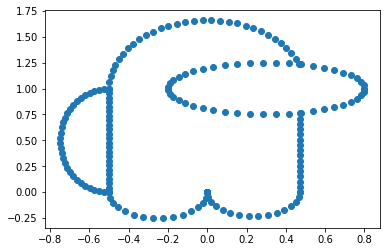

In [159]:
n=200


dimensions = [200, 200, 200, 200, 200]
#dimensions = [400, 400, 400, 400, 400]

powers=[-0.75, -0.75, -0.75, -0.75, -0.75]
C=[0.70, 0.75, 0.90, 1.15, 1.40]


Xs = dimensions.copy()



#One Clusters
c = 0.1
power = -0.9
Xs[0] = np.random.multivariate_normal(np.zeros(dimensions[1]), c* np.power(dimensions[1],power)*np.identity(dimensions[1]), size = n)


#Two Clusters
distance = 4.5

Xs[1] = TwoGuassians(NumPointsInCluster=int(n/2) ,distance=distance, dim=dimensions[0])

#Four Clusters
distance = 4.5

NumPointsInCluster = int(n/4)
u = np.zeros(dimensions[2])

X = np.zeros((n, dimensions[2]))
X[0:NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[0]=distance
X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[1]=distance
X[2*NumPointsInCluster:3*NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[0]=0
X[3*NumPointsInCluster:n] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
Xs[2] = X


#A circle
pts = np.linspace(0,2*np.pi, num=n)
dataX = np.cos(pts)
dataY = np.sin(pts)

Xs[3] = np.zeros((n, dimensions[1]))
Xs[3][:,0]=dataX 
Xs[3][:,1]=dataY


#Among us?

Xs[4] = makeAmongUS(n, dimensions[4])

In [160]:
#Make the data into epsilon simplexes

C= 0.008
decimals = 4 #note that 4 works pertty well.


Ds = dimensions.copy()

#Ds[0] = distanceSquaredArray2(np.matmul(Xs[0], np.transpose(Xs[0])))
#Ds[0] = Ds[0]/np.min(Ds[0]+np.max(Ds[0])*np.identity(Ds[0].shape[0]))
Ds[0] = makeEsimplexDistance(Xs[0], C, decimals=decimals)
Ds[1] = makeEsimplexDistance(Xs[1], C, decimals = decimals)
Ds[2] = makeEsimplexDistance(Xs[2], C, decimals = decimals)
Ds[3] = makeEsimplexDistance(Xs[3], C, decimals = decimals)
Ds[4] = makeEsimplexDistance(Xs[4], C, decimals = decimals)

maxval = -1
minval = 10
for i in range(len(Ds)):
    #Ds[i] = np.round(Ds[i], decimals = 4)
    maxplace = np.max(Ds[i])
    minplace = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    print(str(i)+" has Dmax = " + str(maxplace) + " and Dmin = " + str(minplace))
    maxval = np.max([maxplace, maxval])
    minval = np.min([minplace, minval])

eps = np.max([maxval/minval - 1.0, 1.0 - minval/maxval])  
print('Eps = '+ str(maxval)+' / '+str(minval)+' = ' +str(eps))

0 has Dmax = 1.0079883190345744 and Dmin = 1.0032462877797181
1 has Dmax = 1.0070402175392823 and Dmin = 1.0010269893749864
2 has Dmax = 1.0056930734114649 and Dmin = 1.0005172996592628
3 has Dmax = 1.0079995015580707 and Dmin = 1.0
4 has Dmax = 1.0078495974929116 and Dmin = 1.0
Eps = 1.0079995015580707 / 1.0 = 0.00799950155807072


/Users/szymonsnoeck/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/szymonsnoeck/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/Users/szymonsnoeck/opt/anaconda3/lib/py

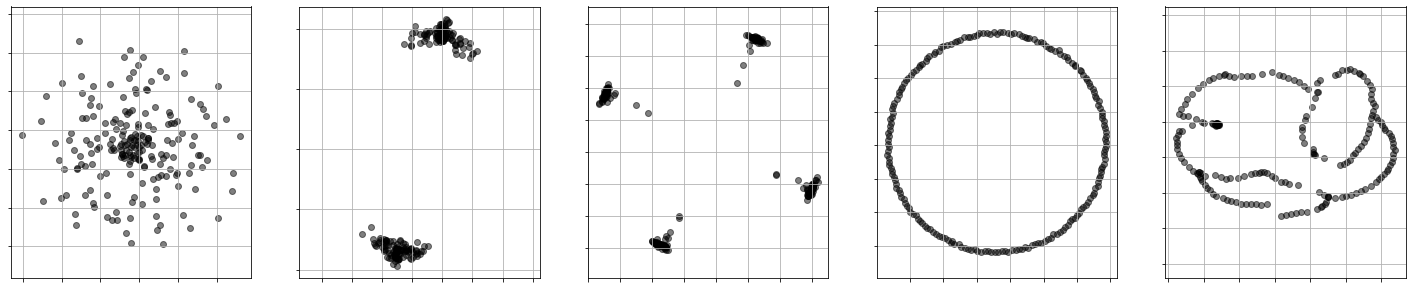

In [162]:
### Running t-SNE w/o PCA ###
#Creating Figure
fig, ax = plt.subplots(nrows=1, ncols=len(Ds))
fig.set_figwidth(len(Ds)*5)
fig.set_figheight(5)

#Setting perplexities
perps=[30, 100, 50, 30, 40]


for i in range(len(Ds)):
        
        #Running T-SNE
        F = TSNE(learning_rate=100, perplexity=perps[i])#, metric='precomputed')
        
        #Plot t-SNE
        Y_features = F.fit_transform(Ds[i])
        Y_xaxis = Y_features[:,0]
        Y_yaxis = Y_features[:,1]

        ax[i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=0.5)
        
        '''
        if i == 0:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of One Cluster')
        elif i == 1:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Two Clusters')
        elif i == 2:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Four Clusters')
        elif i == 3:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of a Circle')
        '''
            
        ax[i].grid('on')
        ax[i].axis('equal')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])

In [154]:
eps=np.round(eps, decimals=3)
fig.savefig('Same_input_diff_out_'+str(eps)+'_woPCA_9_21_25_wAmongus.png')
fig.savefig('Same_input_diff_out_'+str(eps)+'_woPCA_9_21_25_wAmongus.jpg')

Dmax = 1.0499999999999998 Dmin = 0.95
Dmax = 1.05 Dmin = 0.95
Dmax = 1.0499999999999998 Dmin = 0.9499999999999998
Dmax = 1.05 Dmin = 0.9500000000000001


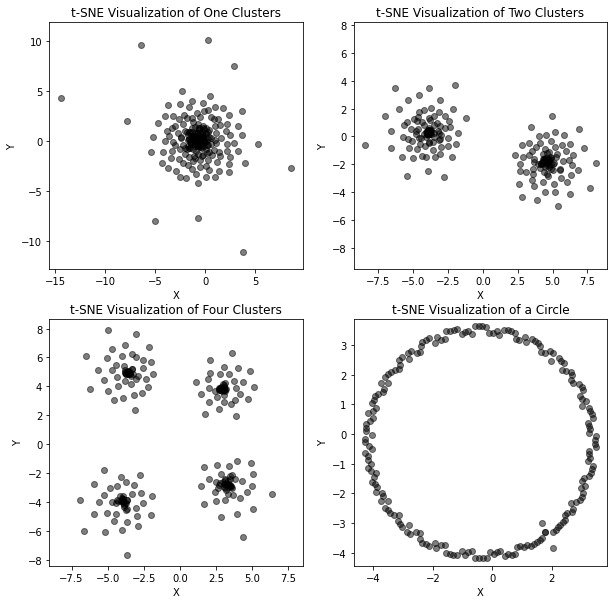

In [266]:
### Running t-SNE with PCA except grid layout ###

#Make the data into epsilon simplexes
eps= 0.05

Xs[0] = makeEsimplex(Xs[0], eps)
Xs[1] = makeEsimplex(Xs[1], eps)
Xs[2] = makeEsimplex(Xs[2], eps)
Xs[3] = makeEsimplex(Xs[3], eps)

#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(10)

#Setting perplexities
perps=[30, 100, 50, 30]


for i in range(2):
    for j in range(2):
        
        #Running T-SNE
        F = TSNE(learning_rate=100, perplexity=perps[i+2*j])
        
        #Plot t-SNE
        Y_features = F.fit_transform(Xs[i+2*j])
        Y_xaxis = Y_features[:,0]
        Y_yaxis = Y_features[:,1]

        ax[j, i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=0.5)
        if i+2*j == 0:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of One Cluster')
        elif i+2*j == 1:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Two Clusters')
        elif i+2*j == 2:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Four Clusters')
        elif i+2*j == 3:
            ax[j, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of a Circle')
            
        ax[j, i].axis('equal')

In [280]:
fig.savefig('Same_input_diff_out_'+str(eps)+'_wPCA_9_20_25.png')
fig.savefig('Same_input_diff_out_'+str(eps)+'_wPCA_9_20_25.jpg')

#### Figure ???: Among Us Imposter

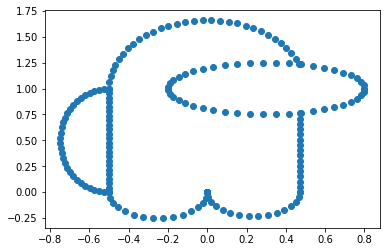

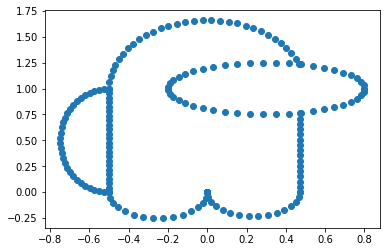

In [164]:
n=200
dimensions = [200, 200]


Xs = dimensions.copy()
Ds = dimensions.copy()

#Among us regular
Xs[0] = makeAmongUS(n, dimensions[0])
Ds[0] = distanceSquaredArray2(np.matmul(Xs[0], np.transpose(Xs[0]))) + np.min(Ds[0])

#Among us eps-simplex
C= 0.008
decimals = 4

Xs[1] = makeAmongUS(n, dimensions[1])
Ds[1] = makeEsimplexDistance(Xs[0], C, decimals = 4)

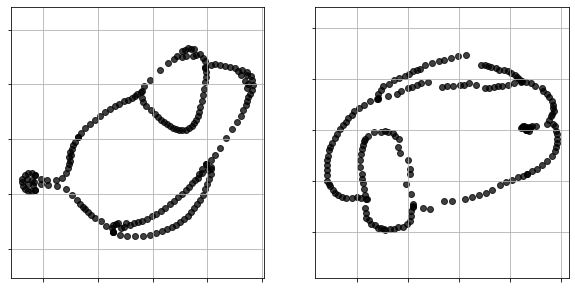

In [178]:
### Running t-SNE w/o PCA ###
#Creating Figure
fig, ax = plt.subplots(nrows=1, ncols=len(Ds))
fig.set_figwidth(len(Ds)*5)
fig.set_figheight(5)

#Setting perplexities
perps=[30, 30]


for i in range(len(Ds)):
        
        #Running T-SNE
        F = TSNE(learning_rate=100, perplexity=perps[i])#, metric='precomputed')
        
        if i == 0:
            #Plot t-SNE
            Y_features = F.fit_transform(Ds[i])
        if i==1:
            Y_features = F.fit_transform(Ds[i])
        
        Y_xaxis = Y_features[:,0]
        Y_yaxis = Y_features[:,1]

        ax[i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=0.75)
            
        ax[i].grid('on')
        ax[i].axis('equal')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])

#### Figure 3 (OLD): Moving One Point For Two Guassians

In [7]:
n=100

dimensions = [2000, 2000]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in range(len(dimensions)):
    X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

In [7]:
#Setting one point to the mean
i=1
Xs[i][50] = np.mean(Xs[i])
Ds[i]=distanceSquaredArray2(np.matmul(Xs[i], np.transpose(Xs[i])))

#Setting one point to the all zeros point
#i=1
#Xs[i][n] =  np.zeros(Xs[i][n].shape)
#Ds[i]=distanceSquaredArray2(np.matmul(Xs[i], np.transpose(Xs[i])))

<ipython-input-8-b7f771c8e074>:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", color='black', alpha=0.65)
<ipython-input-8-b7f771c8e074>:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", color='black', alpha=0.65)


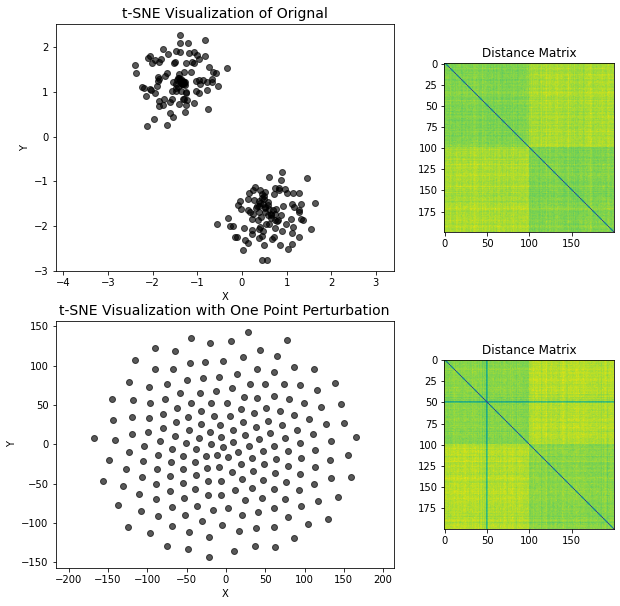

In [8]:
#Creating nicer figure

#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds), gridspec_kw={'width_ratios': [2, 1]})
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[i, 0].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", color='black', alpha=0.65)
    if i==0:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization of Orignal', fontsize=14, weight='light')
    if i==1:
        ax[i, 0].set(xlabel='X', ylabel='Y')
        ax[i, 0].set_title('t-SNE Visualization with One Point Perturbation', fontsize=14, weight='light')
        
    ax[i, 0].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[i, 1].imshow(Ds[i])
    
    if i ==0:
        ax[i, 1].set(title='Distance Matrix') #of Student\'s t-Distribution')
    if i ==1:
        ax[i, 1].set(title='Distance Matrix') #of Guassian Distribution')

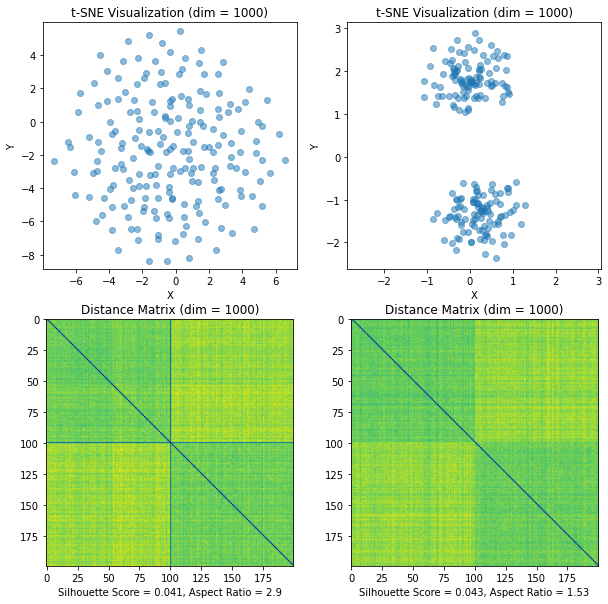

In [64]:
#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds))
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[0, i].scatter(Y_xaxis, Y_yaxis, marker="o", cmap="bwr_r", alpha=0.5)
    ax[0, i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization (dim = '+ str(dimensions[i])+')')
    ax[0, i].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[1, i].imshow(Ds[i])
    ax[1, i].set(title='Distance Matrix (dim = '+ str(dimensions[i])+')', xlabel='Silhouette Score = ' + str(np.round(ASS,decimals=3))+', Aspect Ratio = '+ str(np.round(aspectRatio,decimals=2)))

In [173]:
#Regenerate bad rolls
i = 0 #Roll to regenerate
X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i])
Xs[i]=X
Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

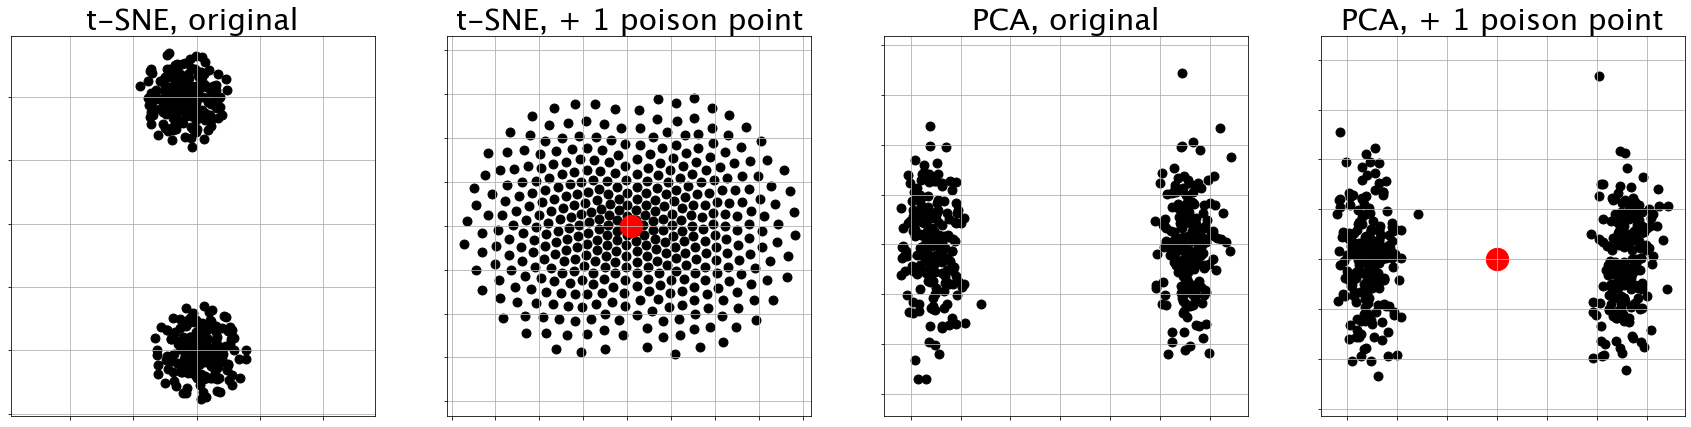

In [9]:
tsne = TSNE(learning_rate=100, perplexity=100)
pca = PCA(n_components=2)
X = TwoGuassians(NumPointsInCluster=200, distance=1, dim=2000)
X1 = np.concatenate((X, np.array( [  np.mean(X, axis=0)  ])), axis=0)

X_tsne0 = tsne.fit_transform(X)
X_tsne1 = tsne.fit_transform(X1)

X_pca0 = pca.fit_transform(X)
X_pca1 = pca.fit_transform(X1)


fig, axs = plt.subplots(1,4, figsize=(30,7))
n = len(X)

for i in range(4):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].scatter(X_tsne0[:,0],X_tsne0[:,1],  s=80,color='black')
axs[0].set_title('t-SNE, original', fontsize=30)

axs[1].scatter(X_tsne1[:-1,0],X_tsne1[:-1,1], s=80, color='black')
axs[1].scatter(X_tsne1[-1,0],X_tsne1[-1,1],  s=500, color='red')
axs[1].set_title('t-SNE, + 1 poison point', fontsize=30)


axs[2].scatter(X_pca0[:,0],X_pca0[:,1],  s=80,color='black')
axs[2].set_title('PCA, original', fontsize=30)

axs[3].scatter(X_pca1[:-1,0],X_pca1[:-1,1], s=80, color='black')
axs[3].scatter(X_pca1[-1,0],X_pca1[-1,1],  s=500, color='red')
axs[3].set_title('PCA, + 1 poison point', fontsize=30)


plt.savefig('visuals/outlier_new/one_pt_perturb.png', bbox_inches='tight' )